# Slash Blur

John Mays | Created: 07/05/2025 | Last Updated: 07/06/2025

## Setup:

In [1]:
from PIL import Image
import random
from tqdm import tqdm
from math import sin, cos, pi
import numpy as np

## Import:

In [14]:
twin = Image.open('../data/in/Aphex Twin Logo.png')

In [15]:
twin = twin.convert('L').convert('RGB')

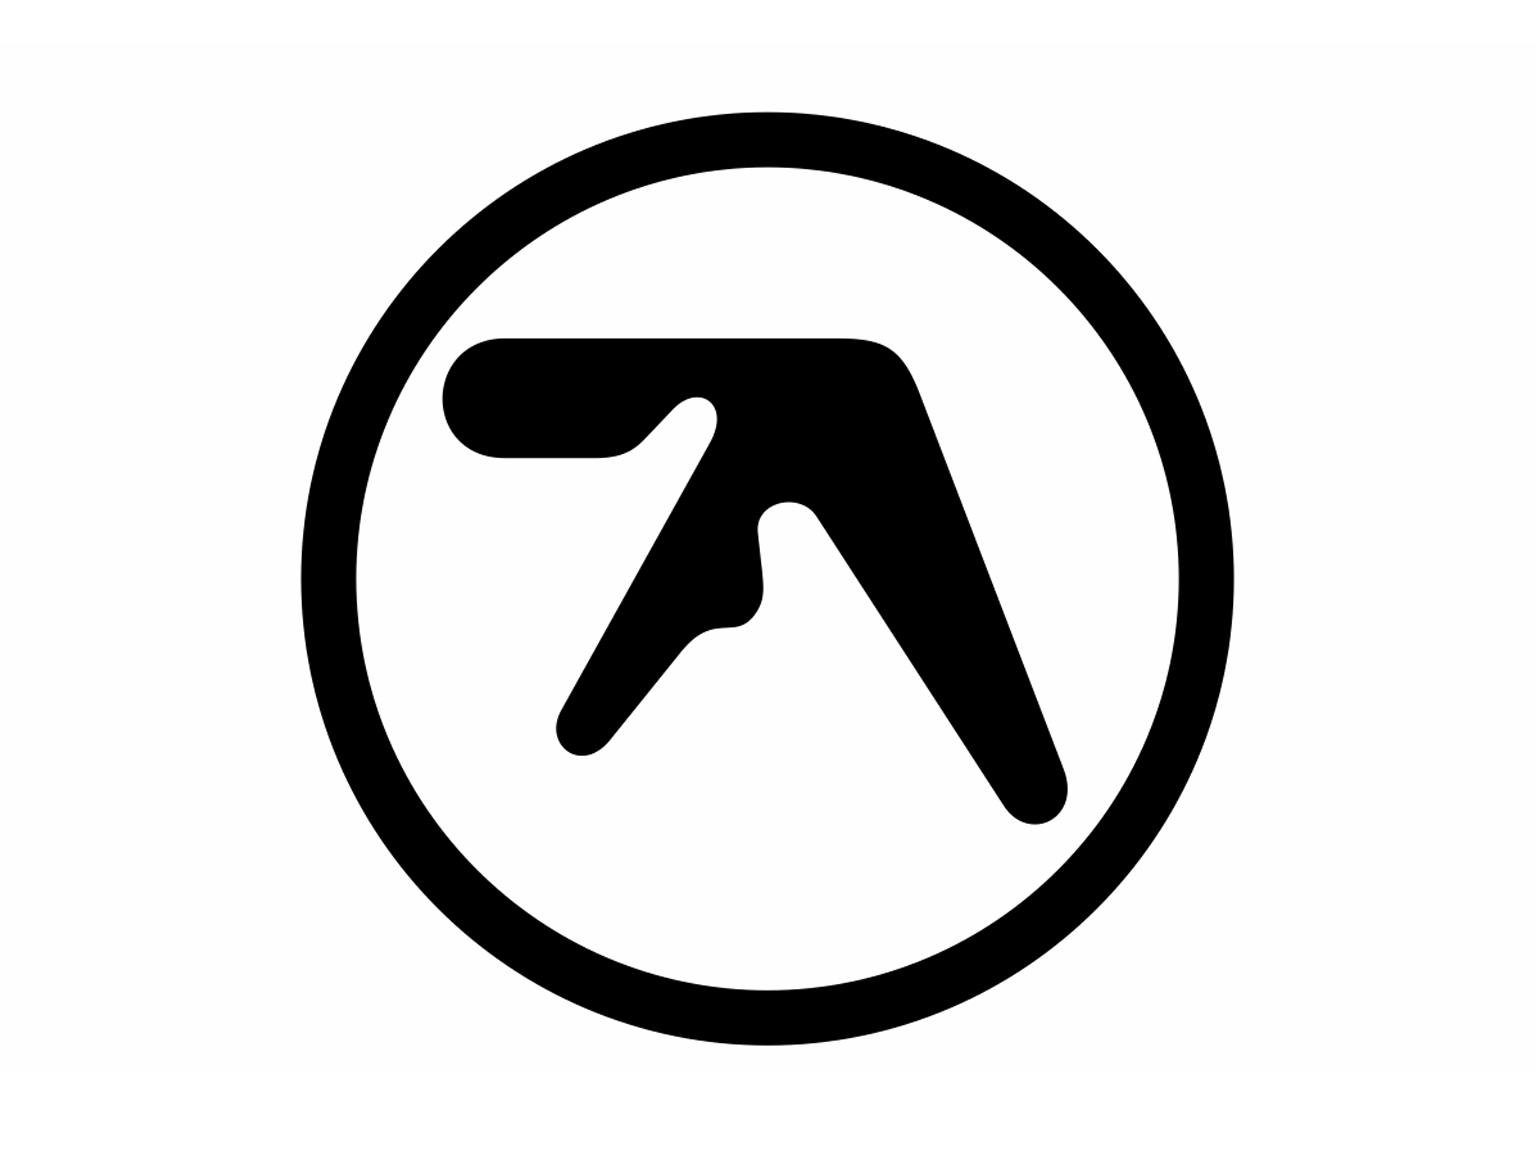

In [16]:
display(twin)

## Algorithm:

In [17]:
class Blur:
    """
    One instance of the Blur class represents one parameterized instance
    of the blur algorithm.
    """

    def __init__(self, concentration:float, slash_length:int, slash_intensity):
        assert concentration >= 0
        assert slash_length >= 1 and slash_length % 2 == 1
        assert 0 <= slash_intensity <= 1

        self.concentration = concentration # average slashes per pixel
        self.slash_length = slash_length # unit: pixels
        self.slash_intensity = slash_intensity # balance between slash and original pixels | 0 is all original. 1 is all slash.
        self.image_bounds = None
    
    def within(self, pixel:tuple) -> bool:
        x, y = pixel
        if x >= self.image_bounds[0] and x < self.image_bounds[2]\
        and y >= self.image_bounds[1] and y < self.image_bounds[3]:
            return True
        return False

    def perform_slash(self, im:Image.Image, center_pixel: tuple) -> None:
        random_angle = random.uniform(-pi/2, pi/2)
        slash = self.get_slash_pixels(center_pixel, random_angle)
        constituent_pixels = []
        for pixel in slash:
            constituent_pixels.append(im.getpixel(pixel))
        averaged_color = self.average_pixels(constituent_pixels)
        for pixel, original_color in zip(slash, constituent_pixels):
            new_color= (
                int(self.slash_intensity*averaged_color[0]+(1-self.slash_intensity)*original_color[0]),
                int(self.slash_intensity*averaged_color[1]+(1-self.slash_intensity)*original_color[0]),
                int(self.slash_intensity*averaged_color[2]+(1-self.slash_intensity)*original_color[2]))
            im.putpixel(pixel, new_color)

    def perform_blur(self, im:Image.Image) -> Image.Image:
        width, height = im.size
        self.image_bounds = (0, 0) + (width, height)
        pixel_count = width*height
        slash_count = int(self.concentration*pixel_count)
        for i in tqdm(range(slash_count)):
            pixel = (random.randint(0, width-1), random.randint(0, height-1))
            self.perform_slash(im, pixel)
        return im
    
    def get_slash_pixels(self, center_pixel, angle) -> list:
        x0, y0 = 0, 0 # initial point at (0,0)
        x1 = round(self.slash_length*sin(angle))
        y1 = round(self.slash_length*cos(angle))
        # Digital Differential Analyzer Algorithm:
        slash_pixels=[]
        dx = x1 - x0
        dy = y1 - y0
        steps = abs(dx) if abs(dx) > abs(dy) else abs(dy)
        xi = (dx/steps) if steps > 0 else 0
        yi = (dy/steps) if steps > 0 else 0

        x = float(x0)
        y = float(y0)

        for _ in range(steps + 1):
            slash_pixels.append((round(x), round(y)))  # Add the current point to the list
            x += xi
            y += yi

        # center slash on center_pixel
        center_slash_pixel = slash_pixels[int(self.slash_length/2)]
        slash_pixels = [self.add_pixel_coordinates(self.subtract_pixel_coordinates(p, center_slash_pixel), center_pixel) for p in slash_pixels]
        return [p for p in slash_pixels if self.within(p)]
    
    def add_pixel_coordinates(self, p1, p2):
        return (p1[0]+p2[0], p1[1]+p2[1])

    def subtract_pixel_coordinates(self, p1, p2):
        return (p1[0]-p2[0], p1[1]-p2[1])
    
    def average_pixels(self, pixel_list:list) -> tuple:
        r, g, b = zip(*pixel_list)
        return (int(np.average(r)), int(np.average(g)), int(np.average(b)))

## Running Algorithm:

In [18]:
blur_1 = Blur(0.1, 9, 1) # so ugly
blur_2 = Blur(1, 11, 1)
blur_3 = Blur(4, 5, 1)
blur_4 = Blur(10, 5, 0.25)

100%|██████████| 17694720/17694720 [11:32<00:00, 25565.68it/s]


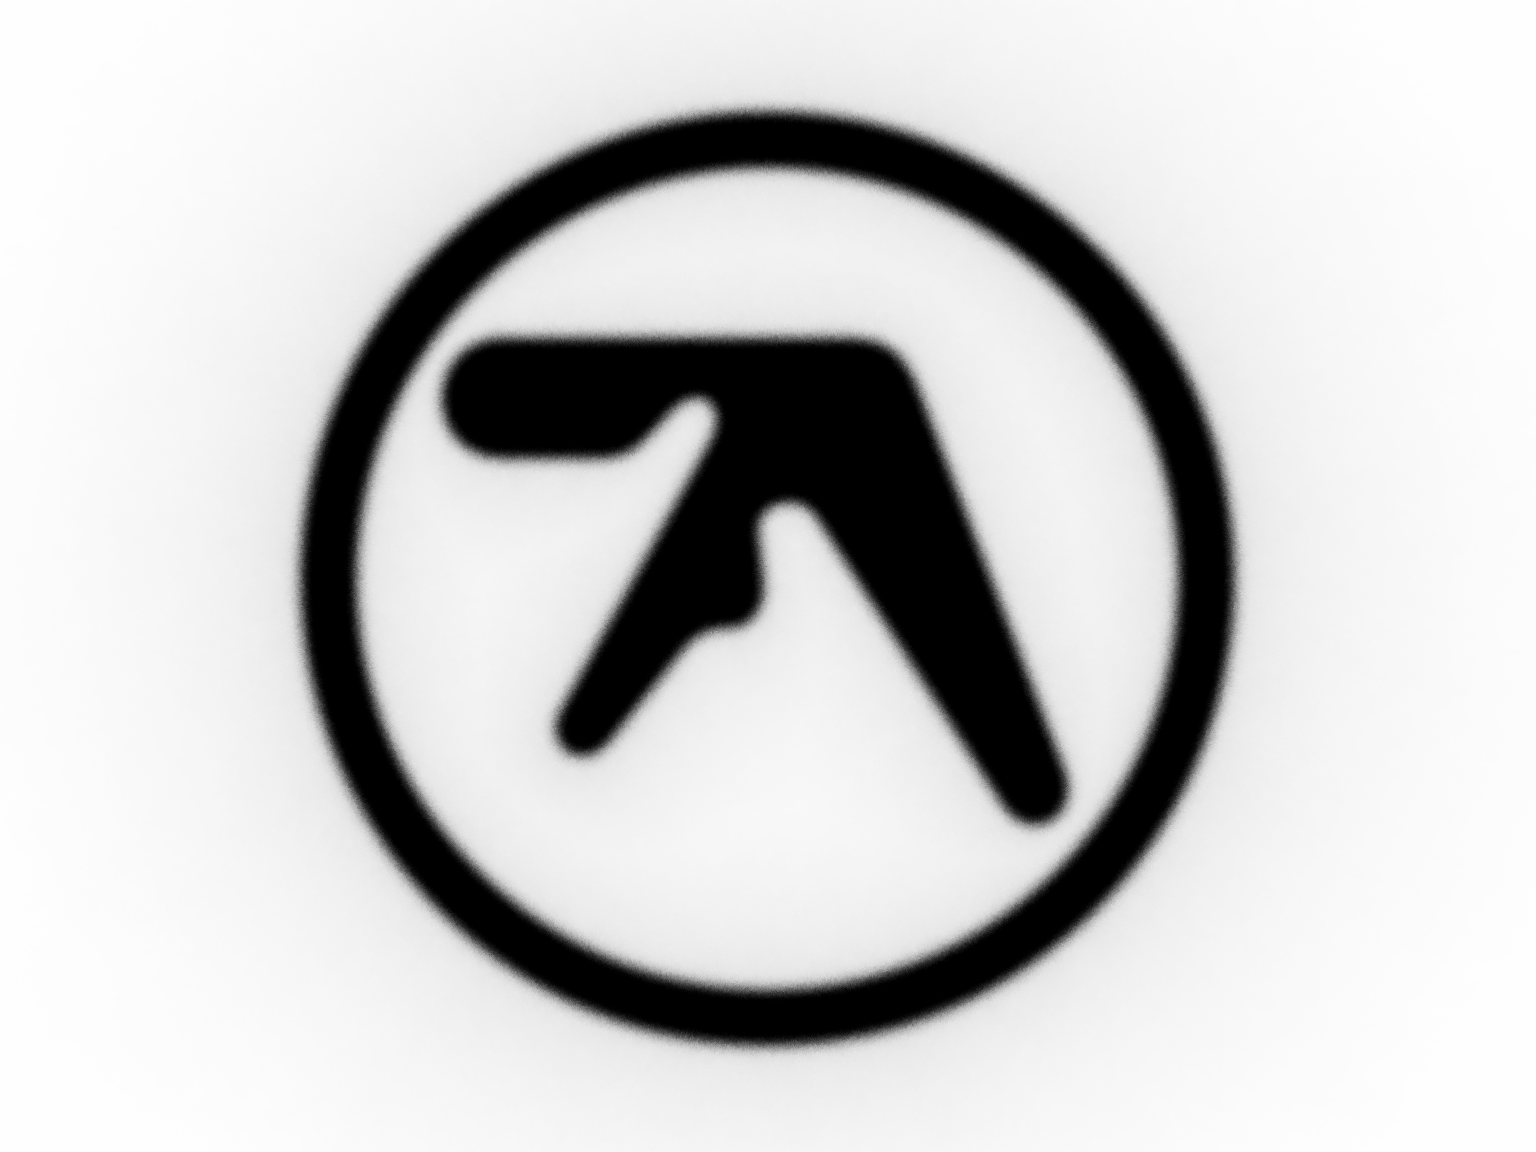

In [19]:
blur_4.perform_blur(twin)
display(twin)

## Output Results:

In [ ]:
# bbox = (200, 100, 900, 600)

In [20]:
twin.save('../data/out/twin_logo_blur4.png')